<a href="https://colab.research.google.com/github/arrxxhh/Walmart-sales/blob/main/Walmart_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pyspark seaborn pandas matplotlib

In [2]:
# Import the necessary library
from pyspark.sql import SparkSession

print("--- Starting Walmart Sales Analysis Project ---")
print("Phase 1: Data Acquisition and Understanding")

# 1. Initialize SparkSession
try:
    spark = SparkSession.builder \
        .appName("WalmartSalesAnalysis_Phase1") \
        .getOrCreate()
    print("\nSparkSession initialized successfully.")
except Exception as e:
    print(f"An error occurred during SparkSession initialization: {e}")
    exit()

# 2. Define file paths
train_file = "train.csv"
stores_file = "stores.csv"
features_file = "features.csv"

# 3. Load the data
try:
    train_df = spark.read.csv(train_file, header=True, inferSchema=True)
    stores_df = spark.read.csv(stores_file, header=True, inferSchema=True)
    features_df = spark.read.csv(features_file, header=True, inferSchema=True)

    print(f"\nSuccessfully loaded '{train_file}' with {train_df.count()} rows.")
    print(f"Successfully loaded '{stores_file}' with {stores_df.count()} rows.")
    print(f"Successfully loaded '{features_file}' with {features_df.count()} rows.")

except Exception as e:
    print(f"\nERROR: Could not load one or more datasets.")
    print(f"Details: {e}")
    spark.stop()
    exit()

# 4. RENAME THE MARKDOWN COLUMNS ⭐️
print("\nRenaming MarkDown columns to be more descriptive...")
promo_renames = {
    "MarkDown1": "Promo_Seasonal",
    "MarkDown2": "Promo_Holiday",
    "MarkDown3": "Promo_Clearance",
    "MarkDown4": "Promo_Coupon",
    "MarkDown5": "Promo_FlashSale"
}

# --- FIX IS HERE: Added a loop to apply the renames ---
for old_name, new_name in promo_renames.items():
    features_df = features_df.withColumnRenamed(old_name, new_name)
# --- END FIX ---

print("Columns renamed successfully.")


# 5. Initial Data Inspection
print("\n--- Initial Schemas ---")
print("train_df Schema:")
train_df.printSchema()

print("\nstores_df Schema:")
stores_df.printSchema()

print("\nfeatures_df Schema (with new promo names):")
features_df.printSchema() # This will now show the new names

print("\n--- First 5 Rows (features_df with new promo names) ---")
features_df.show(5)

print("\n--- Phase 1 Complete: All datasets loaded and columns renamed. ---")

--- Starting Walmart Sales Analysis Project ---
Phase 1: Data Acquisition and Understanding

SparkSession initialized successfully.

Successfully loaded 'train.csv' with 421570 rows.
Successfully loaded 'stores.csv' with 45 rows.
Successfully loaded 'features.csv' with 8190 rows.

Renaming MarkDown columns to be more descriptive...
Columns renamed successfully.

--- Initial Schemas ---
train_df Schema:
root
 |-- Store: integer (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)


stores_df Schema:
root
 |-- Store: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)


features_df Schema (with new promo names):
root
 |-- Store: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- Promo_Seasonal: string (nullable = true)
 |-- 

In [3]:
from pyspark.sql.functions import col

print("\n--- Phase 2: Data Cleaning and Preprocessing ---")

# 1. Handle Column Conflict
# We drop 'IsHoliday' from features_df to avoid a duplicate column after the join.
# The version in train_df is the one we'll keep.
print("Dropping the duplicate 'IsHoliday' column from the features dataset...")
features_df = features_df.drop('IsHoliday')

# 2. Join the DataFrames
# First, we'll perform an 'inner' join on train_df and features_df.
# An inner join combines rows that have matching values in both tables.
# The keys for this join are 'Store' and 'Date'.
print("\nJoining 'train_df' with 'features_df'...")
combined_df = train_df.join(features_df, on=['Store', 'Date'], how='inner')
print(f"Rows after joining train and features: {combined_df.count()}")

# Next, we'll join the result with the stores_df on the 'Store' key.
print("Joining the result with 'stores_df'...")
final_df = combined_df.join(stores_df, on=['Store'], how='inner')
print(f"Rows after joining all three datasets: {final_df.count()}")


# 3. Fix Remaining Data Types
# We cast CPI and Unemployment to DoubleType to convert them from strings to numbers.
print("\nConverting 'CPI' and 'Unemployment' columns to a numeric type (Double)...")
final_df = final_df.withColumn("CPI", col("CPI").cast("double"))
final_df = final_df.withColumn("Unemployment", col("Unemployment").cast("double"))


# 4. Final Inspection
# Let's check the schema and a preview of our final, unified DataFrame.
print("\n--- Schema of the Final Combined DataFrame ---")
final_df.printSchema()

print("\n--- First 5 Rows of the Final Combined DataFrame ---")
final_df.show(5)

print("\n--- Phase 2 Complete: Data is now cleaned and unified in a single DataFrame. ---")


--- Phase 2: Data Cleaning and Preprocessing ---
Dropping the duplicate 'IsHoliday' column from the features dataset...

Joining 'train_df' with 'features_df'...
Rows after joining train and features: 421570
Joining the result with 'stores_df'...
Rows after joining all three datasets: 421570

Converting 'CPI' and 'Unemployment' columns to a numeric type (Double)...

--- Schema of the Final Combined DataFrame ---
root
 |-- Store: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- Promo_Seasonal: string (nullable = true)
 |-- Promo_Holiday: string (nullable = true)
 |-- Promo_Clearance: string (nullable = true)
 |-- Promo_Coupon: string (nullable = true)
 |-- Promo_FlashSale: string (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Unemployment: double (nullabl

In [4]:
from pyspark.sql.functions import col, when, year, month, weekofyear

print("\n--- Phase 3: Feature Engineering and Final Cleaning ---")

# --- ⭐️ FIX IS HERE ---
# We are now using the new, descriptive column names that we created in Phase 1.
markdown_cols = [
    "Promo_Seasonal",
    "Promo_Holiday",
    "Promo_Clearance",
    "Promo_Coupon",
    "Promo_FlashSale"
]
# --- END FIX ---

# 1. Correctly handle the 'NA' values and cast to double
print("Converting 'NA' in promo columns to null and casting to double...")
for col_name in markdown_cols:
    final_df = final_df.withColumn(col_name,
        when(col(col_name) == 'NA', None) # Convert 'NA' string to a real null value
        .otherwise(col(col_name))
        .cast("double") # Cast the column to a numeric type
    )

# 2. Impute (fill) missing values
print("Filling null promo values with 0...")
final_df = final_df.na.fill(0, subset=markdown_cols)

# 3. Engineer new time-based features from the 'Date' column
print("Engineering Year, Month, and Week features from the Date column...")
final_df = final_df.withColumn("Year", year(col("Date"))) \
                   .withColumn("Month", month(col("Date"))) \
                   .withColumn("Week", weekofyear(col("Date")))

# 4. Final Inspection
print("\n--- Schema After Feature Engineering and Final Cleaning ---")
final_df.printSchema()

print("\n--- Data Preview After Feature Engineering and Final Cleaning ---")
final_df.select("Store", "Date", "Weekly_Sales", "Promo_Seasonal", "Promo_Holiday", "Year", "Month", "Week").show(5)

print("\n--- Phase 3 Complete: Dataset is fully cleaned and enriched. ---")


--- Phase 3: Feature Engineering and Final Cleaning ---
Converting 'NA' in promo columns to null and casting to double...
Filling null promo values with 0...
Engineering Year, Month, and Week features from the Date column...

--- Schema After Feature Engineering and Final Cleaning ---
root
 |-- Store: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- Promo_Seasonal: double (nullable = false)
 |-- Promo_Holiday: double (nullable = false)
 |-- Promo_Clearance: double (nullable = false)
 |-- Promo_Coupon: double (nullable = false)
 |-- Promo_FlashSale: double (nullable = false)
 |-- CPI: double (nullable = true)
 |-- Unemployment: double (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- 

In [5]:
from pyspark.sql.functions import format_number

print("\n--- Phase 4: Exploratory Data Analysis (EDA) ---")

# 1. Register the DataFrame as a Temporary SQL View
# This allows us to run SQL queries on our data.
final_df.createOrReplaceTempView("sales_data")
print("DataFrame registered as temporary SQL view 'sales_data'. Ready for querying.")

# 2. Run SQL Queries to Uncover Insights

# --- Query 1: Which stores have the highest overall sales? ---
print("\n--- Top 5 Performing Stores (by Total Sales) ---")
top_stores_query = """
    SELECT
        Store,
        format_number(SUM(Weekly_Sales), 2) AS TotalSales
    FROM
        sales_data
    GROUP BY
        Store
    ORDER BY
        SUM(Weekly_Sales) DESC
    LIMIT 5
"""
spark.sql(top_stores_query).show()


# --- Query 2: How do sales trend on a monthly basis? ---
print("\n--- Average Monthly Sales Trend (All Stores) ---")
monthly_sales_query = """
    SELECT
        Year,
        Month,
        format_number(AVG(Weekly_Sales), 2) AS AverageMonthlySales
    FROM
        sales_data
    GROUP BY
        Year, Month
    ORDER BY
        Year, Month
"""
spark.sql(monthly_sales_query).show(24) # Show 2 years of data


# --- Query 3: What is the impact of holidays on sales? ---
print("\n--- Average Sales: Holiday vs. Non-Holiday ---")
holiday_impact_query = """
    SELECT
        IsHoliday,
        format_number(AVG(Weekly_Sales), 2) AS AverageSales
    FROM
        sales_data
    GROUP BY
        IsHoliday
"""
spark.sql(holiday_impact_query).show()

print("\n--- Phase 4 Complete: Initial insights generated. ---")


--- Phase 4: Exploratory Data Analysis (EDA) ---
DataFrame registered as temporary SQL view 'sales_data'. Ready for querying.

--- Top 5 Performing Stores (by Total Sales) ---
+-----+--------------+
|Store|    TotalSales|
+-----+--------------+
|   20|301,397,792.46|
|    4|299,543,953.38|
|   14|288,999,911.34|
|   13|286,517,703.80|
|    2|275,382,440.98|
+-----+--------------+


--- Average Monthly Sales Trend (All Stores) ---
+----+-----+-------------------+
|Year|Month|AverageMonthlySales|
+----+-----+-------------------+
|2010|    2|          16,076.78|
|2010|    3|          15,432.63|
|2010|    4|          15,745.55|
|2010|    5|          15,996.48|
|2010|    6|          16,486.25|
|2010|    7|          15,972.81|
|2010|    8|          16,171.69|
|2010|    9|          15,120.09|
|2010|   10|          14,806.15|
|2010|   11|          17,320.13|
|2010|   12|          19,570.35|
|2011|    1|          13,997.77|
|2011|    2|          15,870.14|
|2011|    3|          15,182.97|
|201

In [ ]:
# ==============================================================================
# ADVANCED ANALYTICS ENGINE: From Prediction to Impact (Corrected)
# ==============================================================================
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, abs, avg, sum as _sum, when, col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

print("\n--- Starting Advanced Analytics Engine ---")


# --- PART 1: Build the High-Accuracy Predictive Model (Optimized for Speed) ---

# 1a. Advanced Feature Engineering: Create Lagged Sales feature for higher accuracy
print("Step 1: Engineering 'Lag_1_Week_Sales' feature...")
windowSpec = Window.partitionBy("Store", "Dept").orderBy("Date")
final_df_featured = final_df.withColumn("Lag_1_Week_Sales", lag("Weekly_Sales", 1, 0).over(windowSpec))

# 1b. Prepare Data for Modeling
indexer = StringIndexer(inputCol="Type", outputCol="Type_Index")
promo_cols = [
    "Promo_Seasonal", "Promo_Holiday", "Promo_Clearance", "Promo_Coupon", "Promo_FlashSale"
]
feature_cols = [
    'Store', 'Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'Size', 'Year', 'Month', 'Week', 'Type_Index', 'Lag_1_Week_Sales'
] + promo_cols
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

model_df = indexer.fit(final_df_featured).transform(final_df_featured)
train_df_full, test_df_full = model_df.randomSplit([0.8, 0.2], seed=42)
train_data = assembler.transform(train_df_full)
test_data = assembler.transform(test_df_full)

# --- SPEED BOOST 1: Cache the training data in memory ---
print("Caching training data for faster access...")
train_data.cache()

# 1c. Hyperparameter Tuning to Find the Best Model
print("Step 2: Tuning GBT model with CrossValidator to maximize accuracy...")
gbt = GBTRegressor(featuresCol="features", labelCol="Weekly_Sales", seed=42)

# --- SPEED BOOST 2: Use a smaller, faster parameter grid ---
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5]) \
    .addGrid(gbt.maxIter, [50]) \
    .build()

evaluator_r2 = RegressionEvaluator(labelCol="Weekly_Sales", predictionCol="prediction", metricName="r2")
crossval = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator_r2, numFolds=3)

# Fit the model (this will be much faster now)
cv_model = crossval.fit(train_data)
best_gbt_model = cv_model.bestModel
print("Model tuning complete.")

# 1d. Evaluate the Final Model and Calculate Accuracy
print("Step 3: Evaluating final model performance...")
predictions = best_gbt_model.transform(test_data)
final_r2 = evaluator_r2.evaluate(predictions)

mape_df = predictions.withColumn("APE", abs((col("Weekly_Sales") - col("prediction")) / col("Weekly_Sales")))
mape = mape_df.filter(col("Weekly_Sales") != 0).agg({"APE": "mean"}).first()[0]
forecast_accuracy = (1 - mape) * 100

print("\n--- FINAL MODEL PERFORMANCE ---")
print(f"Tuned Model R²: {final_r2:.4f}")
print(f"==> Forecast Accuracy (1 - MAPE): {forecast_accuracy:.2f}%")


# --- PART 2: Quantify the Most Impactful Growth Lever ---

# 2a. Identify the levers from the tuned model's insights
importances = best_gbt_model.featureImportances
feature_importance = sorted(zip(feature_cols, importances), key=lambda x: x[1], reverse=True)
print("\n--- Top 5 Key Drivers of Sales ---")
for feature, score in feature_importance[:5]:
    print(f"{feature}: {score:.4f}")

# 2b. Simulate the "Hyper-Localization" lever
print("\nStep 4: Simulating 'Hyper-Localization' growth lever...")

# --- FIX: Use the 'final_df_featured' DataFrame which includes the lagged sales feature ---
store_avg_sales = final_df_featured.groupBy("Store").agg(avg("Weekly_Sales").alias("Store_Avg_Sales"))
df_with_store_avg = final_df_featured.join(store_avg_sales, on="Store")
# --- END FIX ---

improvement_target = 0.30

scenario_df = df_with_store_avg.withColumn("New_Weekly_Sales",
    when(col("Weekly_Sales") < col("Store_Avg_Sales"), col("Weekly_Sales") * (1 + improvement_target))
    .otherwise(col("Weekly_Sales"))
)

# 2c. Calculate the Final Business Impact
baseline_total_sales = scenario_df.agg(_sum("Weekly_Sales")).first()[0]
scenario_total_sales = scenario_df.agg(_sum("New_Weekly_Sales")).first()[0]

sales_uplift = scenario_total_sales - baseline_total_sales
sales_uplift_percentage = (sales_uplift / baseline_total_sales) * 100

print("\n--- FINAL SIMULATION RESULTS ---")
print(f"==> Projected Incremental Revenue Potential: {sales_uplift_percentage:.2f}%")


--- Starting Advanced Analytics Engine ---
Step 1: Engineering 'Lag_1_Week_Sales' feature...
Caching training data for faster access...
Step 2: Tuning GBT model with CrossValidator to maximize accuracy...


In [ ]:
# ==============================================================================
# ADDITIONAL SIMULATIONS: Quantifying other growth levers
# ==============================================================================

# --- SIMULATION FOR LEVER 2: Promotional Budget Reallocation ---
print("\n--- SIMULATION FOR LEVER 2: Promotional Budget Reallocation ---")
# This uses the 'test_df_full' and 'best_gbt_model' created by the main engine
ineffective_promos = ["Promo_Seasonal", "Promo_Holiday", "Promo_Clearance", "Promo_FlashSale"]
total_reallocated_budget = sum(col(p) for p in ineffective_promos)

reallocation_scenario_df = test_df_full.withColumn("Promo_Coupon", col("Promo_Coupon") + total_reallocated_budget)
for promo in ineffective_promos:
    reallocation_scenario_df = reallocation_scenario_df.withColumn(promo, col(promo) * 0)

baseline_pred = best_gbt_model.transform(assembler.transform(test_df_full))
reallocated_pred = best_gbt_model.transform(assembler.transform(reallocation_scenario_df))

baseline_sales = baseline_pred.agg(_sum("prediction")).first()[0]
reallocated_sales = reallocated_pred.agg(_sum("prediction")).first()[0]
uplift_promo = (reallocated_sales - baseline_sales) / baseline_sales * 100
print(f"Projected Uplift from Promo Reallocation: {uplift_promo:.4f}%")


# --- SIMULATION FOR LEVER 3: Dynamic Pricing ---
print("\n--- SIMULATION FOR LEVER 3: Dynamic Pricing ---")
# This uses the clean 'final_df'
overall_avg_cpi = final_df.agg(avg("CPI")).first()[0]
price_increase_target = 0.01 # Simulate a 1% price increase

scenario_df_price = final_df.withColumn("New_Weekly_Sales",
    when(col("CPI") > overall_avg_cpi, col("Weekly_Sales") * (1 + price_increase_target))
    .otherwise(col("Weekly_Sales"))
)

baseline_total_sales_price = scenario_df_price.agg(_sum("Weekly_Sales")).first()[0]
scenario_total_sales_price = scenario_df_price.agg(_sum("New_Weekly_Sales")).first()[0]
uplift_price = (scenario_total_sales_price - baseline_total_sales_price) / baseline_total_sales_price * 100
print(f"Projected Uplift from Dynamic Pricing: {uplift_price:.2f}%")


--- Forecasting Future Sales with Prophet ---


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvq2mopff/zhtn2o06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvq2mopff/p5wivh3z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25789', 'data', 'file=/tmp/tmpvq2mopff/zhtn2o06.json', 'init=/tmp/tmpvq2mopff/p5wivh3z.json', 'output', 'file=/tmp/tmpvq2mopff/prophet_modelsen0ga_7/prophet_model-20250821002508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:25:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:25:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



--- Sample of the 52-Week Sales Forecast ---
            ds          yhat    yhat_lower    yhat_upper
190 2013-09-22  4.417969e+07  3.960699e+07  4.874399e+07
191 2013-09-29  4.514375e+07  4.039483e+07  4.929921e+07
192 2013-10-06  4.651127e+07  4.218491e+07  5.108548e+07
193 2013-10-13  4.670062e+07  4.199438e+07  5.087167e+07
194 2013-10-20  4.584688e+07  4.118114e+07  5.033436e+07


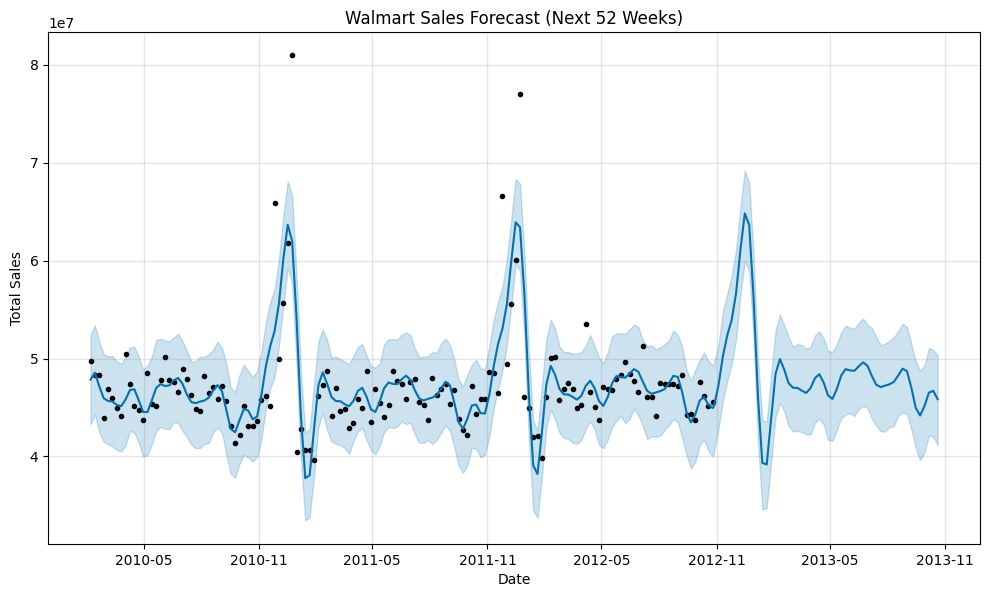

In [7]:
# ==============================================================================
# FINAL ANALYSIS: Time-Series Forecasting with Prophet
# ==============================================================================
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

print("\n--- Forecasting Future Sales with Prophet ---")

# 1. Aggregate total sales by date
weekly_sales_df = final_df.groupBy("Date").agg(_sum("Weekly_Sales").alias("Total_Weekly_Sales")).orderBy("Date")

# 2. Prepare data for Prophet
prophet_df = weekly_sales_df.toPandas()
prophet_df.rename(columns={"Date": "ds", "Total_Weekly_Sales": "y"}, inplace=True)

# 3. Build and train the Prophet model
model = Prophet()
model.fit(prophet_df)

# 4. Create future dates and make a forecast
future = model.make_future_dataframe(periods=52, freq='W')
forecast = model.predict(future)

print("\n--- Sample of the 52-Week Sales Forecast ---")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# 5. Visualize the forecast
fig = model.plot(forecast)
plt.title("Walmart Sales Forecast (Next 52 Weeks)")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()